In [7]:
import escape_time_threshold as ETT
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import colors 

In [8]:
config = {
    "montecarlokey": "monte-carlo-000",
    "GCname": "Pal5",
    "MWpotential": "pouliasis2017pii",
    "NP": int(1e5),
}

In [3]:
factor_step = 10
# load data
stream_path     = "/scratch2/sferrone/simulations/Streams/"+config["MWpotential"]+"/"+config["GCname"]+"/"+str(config["NP"])+"/"
stream_filename = config["GCname"] + "-streams-" + config['montecarlokey'] + ".hdf5"

In [4]:
tesc,x,y,z,vx,vy,vz = ETT.load_stream(stream_path+stream_filename,config)

In [13]:
### PREPARE THE PLOT     
nbins = int(np.ceil(np.sqrt(config["NP"])))
tesc_escape_only = tesc[tesc <=0]
### PREPARE PLOT 
norm = colors.Normalize(vmin=tesc.min(), vmax=0)
cmap = plt.cm.rainbow

## PICK OUR CURRENT THRESHOLD 
threshold=ETT.threshold_factor(tesc, 30000)


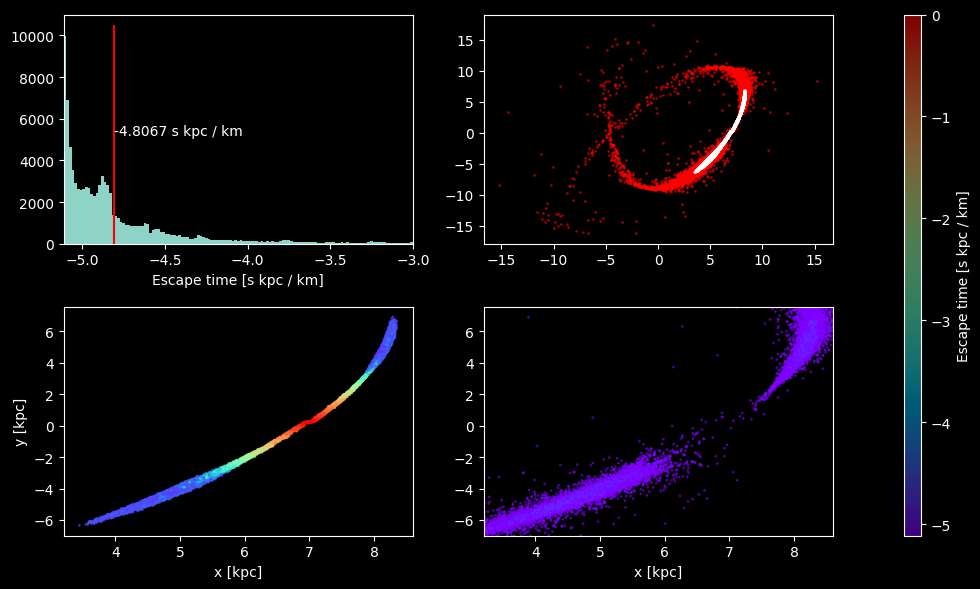

In [14]:
fig, ax0, ax1, ax2, ax3, ax4 = ETT.set_up_gridspec()
fig, ax0, ax1, ax2, ax3, ax4 = ETT.fill_in_plot(fig,ax0, ax1, ax2, ax3, ax4, cmap, norm, tesc_escape_only, tesc,  x, y, threshold, nbins)

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colors 
import numpy as np
import h5py
from astropy import units as u

The stream is artifically thick, is this because of using a plummer for Palomar 5 was a poor model choice?
Let us investigate 


In [2]:
config = {
    "montecarlokey": "monte-carlo-000",
    "GCname": "Pal5",
    "MWpotential": "pouliasis2017pii",
    "NP": int(1e5),
}

In [3]:
stream_path     = "/scratch2/sferrone/simulations/Streams/"+config["MWpotential"]+"/"+config["GCname"]+"/"+str(config["NP"])+"/"
stream_filename = config["GCname"] + "-streams-" + config['montecarlokey'] + ".hdf5"

In [4]:
mystream = h5py.File(stream_path+stream_filename, 'r')

In [5]:
tesc=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['tesc'][:]
x=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['x'][:]
y=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['y'][:]
z=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['z'][:]
vx=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['vx'][:]
vy=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['vy'][:]
vz=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['vz'][:]

## Change the non escaped particles to positive times
tesc[tesc==tesc.min()]=999

In [6]:
dt = 1e4*u.yr
dt=dt.to(u.s*u.kpc/u.km).value
threshold = tesc.min() + 30000*dt
cond = tesc < threshold

In [8]:
norm = colors.Normalize(vmin=tesc.min(), vmax=0)
cmap = plt.cm.rainbow

In [9]:
nbins = int(np.ceil(np.sqrt(config["NP"])))
tesc_escape_only = tesc[tesc <=0]

In [10]:
plt.style.use("dark_background")


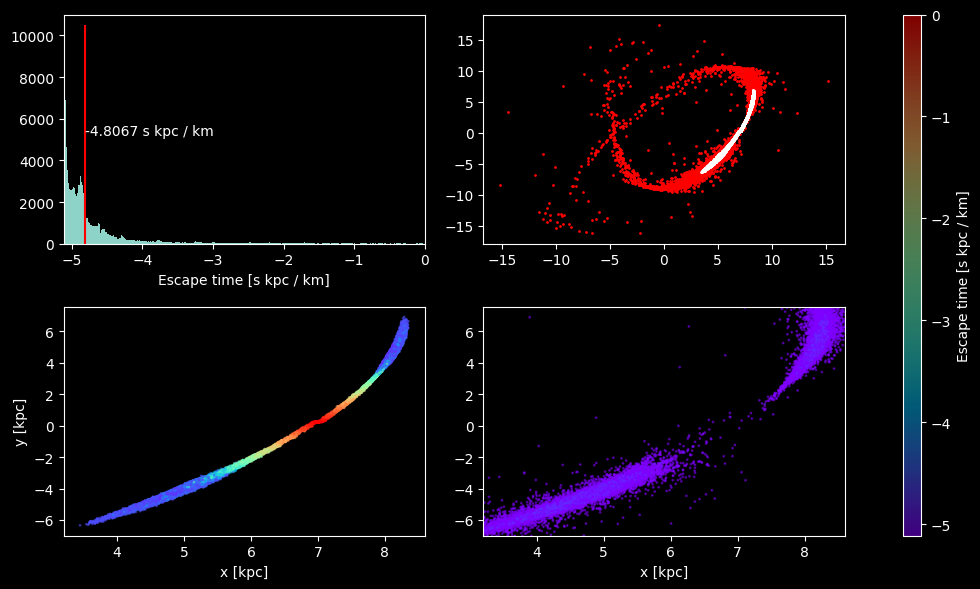

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(10, 6))
# Define GridSpec layout
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], height_ratios=[1, 1])
# Top row, one long plot
ax0 = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[0, 0])
# Bottom row, two axes of similar size
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
# Third column, skinny plot for colorbar
ax4 = fig.add_subplot(gs[:, 2])




### The top plot 
ax1.hist(tesc_escape_only,bins=nbins)
ax1.set_xlim(tesc.min(),0)
ylims=ax1.get_ylim()
ax1.vlines(threshold,ylims[0],ylims[1],colors='r',)
words = "{:.4f} s kpc / km".format(threshold)
ax1.text(threshold,ylims[1]//2,words)

ax0.scatter(x[cond],y[cond],s=1,color="r")
ax0.scatter(x[~cond],y[~cond],s=1,color="w")


## the middle plots 
sc0 = ax2.scatter(x[~cond],y[~cond],c=tesc[~cond],cmap=cmap,norm=norm,s=1,alpha=0.5)
sc1 = ax3.scatter(x[cond],y[cond],c=tesc[cond],cmap=cmap,norm=norm,s=1,alpha=0.5)
cbar = fig.colorbar(sc0, cax=ax4)
cbar.set_label('Escape time [s kpc / km]')
ax1.set_xlabel('Escape time [s kpc / km]')


xlims,ylims=ax2.get_xlim(),ax2.get_ylim()

ax3.set_xlim(xlims)
ax3.set_ylim(ylims)

ax2.set_ylabel('y [kpc]')
ax2.set_xlabel('x [kpc]')
ax3.set_xlabel('x [kpc]')
fig.tight_layout()


In [1]:
import escape_time_threshold as ETT

In [2]:
config = {
    "montecarlokey": "monte-carlo-000",
    "GCname": "Pal5",
    "MWpotential": "pouliasis2017pii",
    "NP": int(1e5),
}


In [3]:
factor_step = 10
# load data
stream_path     = "/scratch2/sferrone/simulations/Streams/"+config["MWpotential"]+"/"+config["GCname"]+"/"+str(config["NP"])+"/"
stream_filename = config["GCname"] + "-streams-" + config['montecarlokey'] + ".hdf5"

In [4]:
tesc,x,y,z,vx,vy,vz = ETT.load_stream(stream_path+stream_filename,config)

TypeError: load_stream() takes 1 positional argument but 2 were given